In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from predictions import make_prediction, PredMetrics, get_prediction_metrics, labels

2024-11-14 09:38:30.882235: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 09:38:30.890505: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 09:38:30.926884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731557310.990803 1145435 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731557311.008017 1145435 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 09:38:31.054801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", 
    mode='max', 
    patience=5, 
    min_delta=0.0001
)

In [3]:
x_train = np.load("../data/preserve100/x_train.npy")
y_train = np.load("../data/preserve100/y_train.npy")
x_test = np.load("../data/preserve100/x_test.npy")
y_test = np.load("../data/preserve100/y_test.npy")

In [18]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2120907, 31)
y_train (2120907, 15)
x_test (706969, 31)
y_test (706969, 1)


In [4]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

In [5]:
model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(31,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(15, activation="softmax")
])

2024-11-14 09:38:35.046958: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
model.compile(optimizer="adamax",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [7]:
model.fit(x_train,
          y_train,
          epochs=10,
          callbacks=[earlystop_callback],
          batch_size=128
         )

Epoch 1/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9445 - loss: 0.1788
Epoch 2/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9699 - loss: 0.0756
Epoch 3/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9744 - loss: 0.0625
Epoch 4/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9768 - loss: 0.0572
Epoch 5/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9779 - loss: 0.0540
Epoch 6/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9790 - loss: 0.0511
Epoch 7/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9795 - loss: 0.0502
Epoch 8/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9803 - loss: 0.0483
Epoch 9/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9806 - loss: 0.0476
Epoch 10/10
16570/16570 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9809 - loss: 0.0468


In [9]:
print("Train Accuracy")
model.evaluate(x_train, 
               y_train, 
               verbose=2)

Train Accuracy
66279/66279 - 72s - 1ms/step - accuracy: 0.9827 - loss: 0.0414


[0.041372206062078476, 0.9826532006263733]

In [10]:
print("Test Accuracy")
model.evaluate(x_test, 
               y_test_onehot, 
               verbose=2)

Test Accuracy
22093/22093 - 22s - 1ms/step - accuracy: 0.9825 - loss: 0.0414


[0.041391775012016296, 0.9824504256248474]

In [19]:
print("Train Model Detailed Report")
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
predictions_train = make_prediction(model, x_train, y_train)
pred_metrics_train = get_prediction_metrics(predictions_train)


print("FP Rate (FPR):", round(pred_metrics_train.weighted_fpr, 4))
print("FN Rate (FNR):", round(pred_metrics_train.weighted_fnr, 4))
print("Detection Rate:", round(pred_metrics_train.weighted_detection_rate, 4))
print("False Alarm Rate (FAR):", round(pred_metrics_train.false_alarm_rate, 4))
print("Accuracy: ", round(pred_metrics_train.classification_report.loc["accuracy"].iloc[0], 4))

pred_metrics_train.classification_report.columns = ["Precision", "Recall", "F1-score", "Quantity"]
pred_metrics_train.classification_report = pred_metrics_train.classification_report.astype({"Quantity": int})
pred_metrics_train.classification_report.drop("accuracy", axis=0, inplace=True)

print("\n", pred_metrics_train.classification_report)

Train Model Detailed Report
66279/66279 ━━━━━━━━━━━━━━━━━━━━ 79s 1ms/step
FP Rate (FPR): 0.1956
FN Rate (FNR): 0.9954
Detection Rate: 0.0046
False Alarm Rate (FAR): 0.5955
Accuracy:  0.0046

                   Precision    Recall  F1-score  Quantity
BENIGN             0.005352  0.021579  0.008576    417816
Bot                0.428662  0.000397  0.000793   1703091
DDoS               0.000000  0.000000  0.000000         0
DoS_GoldenEye      0.000000  0.000000  0.000000         0
DoS_Hulk           0.000000  0.000000  0.000000         0
DoS_Slowhttptest   0.000000  0.000000  0.000000         0
DoS_slowloris      0.000000  0.000000  0.000000         0
FTPPatator         0.000000  0.000000  0.000000         0
Infiltration       0.000000  0.000000  0.000000         0
PortScan           0.000000  0.000000  0.000000         0
SSHPatator         0.000000  0.000000  0.000000         0
macro avg          0.039456  0.001998  0.000852   2120907
weighted avg       0.345270  0.004570  0.002326   2120

In [12]:
print("Test Model Detailed Report")
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)
predictions = make_prediction(model, x_test, y_test)
pred_metrics = get_prediction_metrics(predictions)


print("FP Rate (FPR):", round(pred_metrics.weighted_fpr, 4))
print("FN Rate (FNR):", round(pred_metrics.weighted_fnr, 4))
print("Detection Rate:", round(pred_metrics.weighted_detection_rate, 4))
print("False Alarm Rate (FAR):", round(pred_metrics.false_alarm_rate, 4))
print("Accuracy: ", round(pred_metrics.classification_report.loc["accuracy"].iloc[0], 4))

pred_metrics.classification_report.columns = ["Precision", "Recall", "F1-score", "Quantity"]
pred_metrics.classification_report = pred_metrics.classification_report.astype({"Quantity": int})
pred_metrics.classification_report.drop("accuracy", axis=0, inplace=True)

print("\n", pred_metrics.classification_report)

Test Model Detailed Report
22093/22093 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
FP Rate (FPR): 0.0192
FN Rate (FNR): 0.0175
Detection Rate: 0.9825
False Alarm Rate (FAR): 0.0184
Accuracy:  0.9825

                           Precision    Recall  F1-score  Quantity
BENIGN                     0.994375  0.983952  0.989136    568229
Bot                        0.575639  0.605372  0.590131       484
DDoS                       0.998352  0.989754  0.994034     31818
DoS_GoldenEye              0.975803  0.972716  0.974257      2529
DoS_Hulk                   0.931931  0.998506  0.964071     57561
DoS_Slowhttptest           0.874064  0.974203  0.921421      1318
DoS_slowloris              0.950232  0.978811  0.964310      1463
FTPPatator                 0.977756  0.991479  0.984569      1995
Heartbleed                 0.000000  0.000000  0.000000         4
Infiltration               0.000000  0.000000  0.000000         7
PortScan                   0.896918  0.950892  0.923117     39566
SSHPatator       

5524/5524 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9822 - loss: 0.0420
Test Accuracy: 0.9825
22093/22093 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


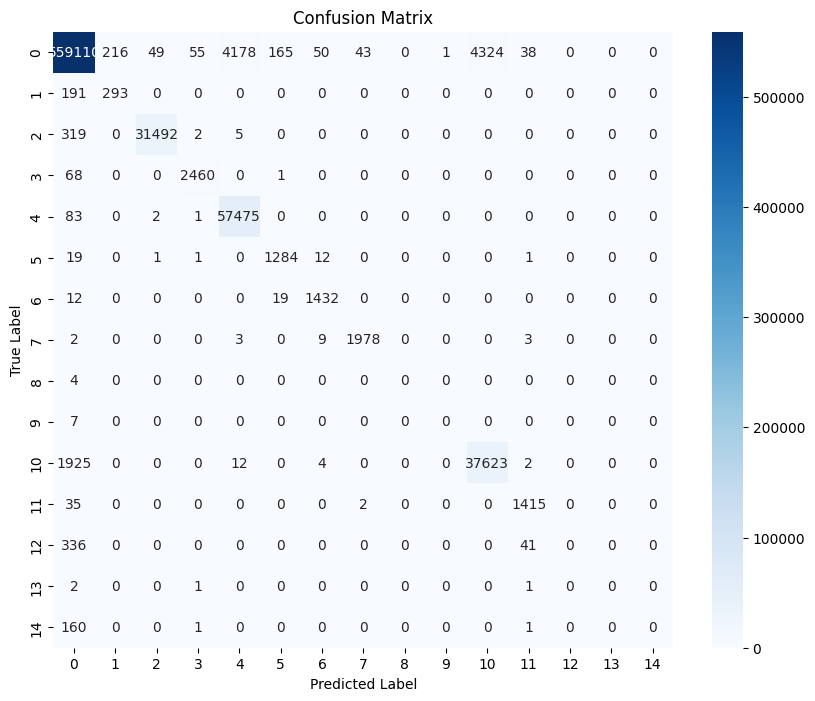

In [15]:
# Evaluate the model on the test data (you can also use x_train and y_train to evaluate training accuracy)
loss, accuracy = model.evaluate(x_test, y_test_onehot, batch_size=128)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

22093/22093 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


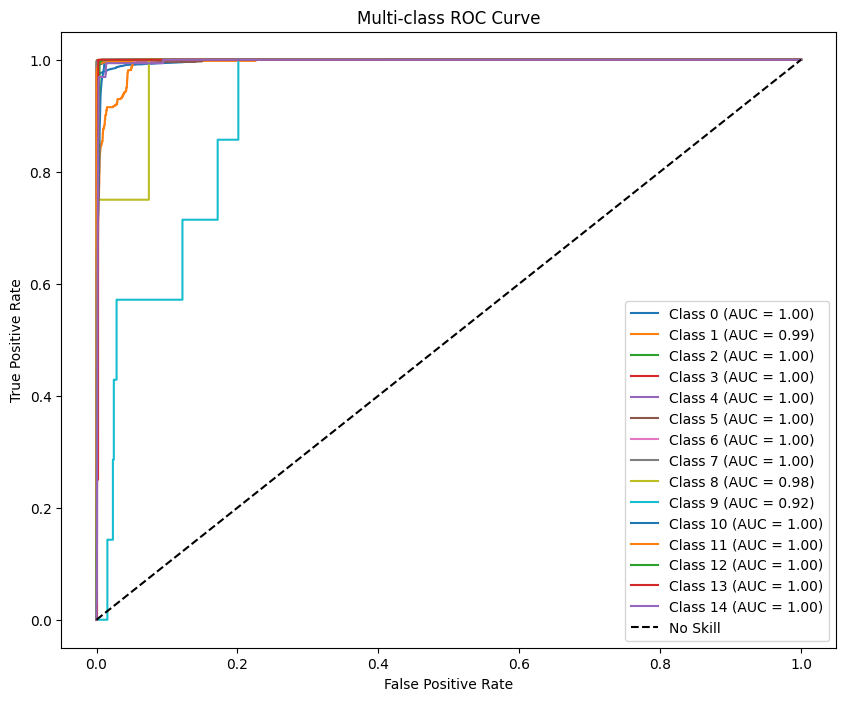

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
num_classes =15
# Assuming `num_classes` is the total number of classes
# Binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

# Step 1: Get predicted probabilities from the classifier
y_pred_prob = model.predict(x_test)  # Probabilities for each class

y_test_binarized = np.nan_to_num(y_test_binarized, nan=0)
y_pred_prob = np.nan_to_num(y_pred_prob, nan=0)

# Step 2: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (no-skill classifier)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

# Finalize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="best")
plt.show()

22093/22093 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


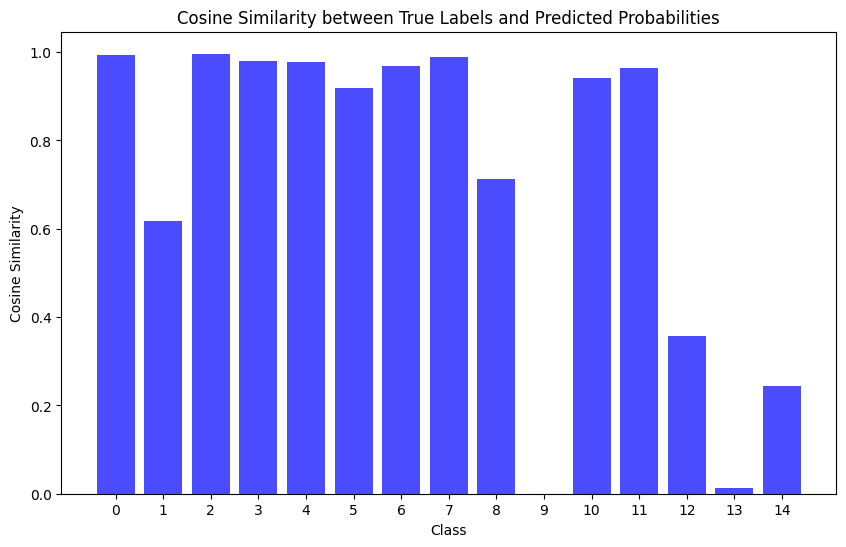

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Assuming `num_classes` is the total number of classes
# Binarize the output for multi-class ROC
num_classes =15
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

# Step 1: Get predicted probabilities from the classifier
y_pred_prob = model.predict(x_test)  # Probabilities for each class

# Ensure no NaN values in the datasets
y_test_binarized = np.nan_to_num(y_test_binarized, nan=0)
y_pred_prob = np.nan_to_num(y_pred_prob, nan=0)

# Step 2: Compute Cosine Similarity between predicted probabilities and actual labels
cosine_similarities = []

for i in range(num_classes):
    similarity = cosine_similarity([y_test_binarized[:, i]], [y_pred_prob[:, i]])[0][0]
    cosine_similarities.append(similarity)


# Step 4: Plot the Cosine Similarity for each class
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), cosine_similarities, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between True Labels and Predicted Probabilities')
plt.xticks(range(num_classes))
plt.show()

Epoch 1/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9813 - loss: 0.0464 - val_accuracy: 0.9825 - val_loss: 0.0407
Epoch 2/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9817 - loss: 0.0454 - val_accuracy: 0.9824 - val_loss: 0.0414
Epoch 3/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9815 - loss: 0.0460 - val_accuracy: 0.9827 - val_loss: 0.0404
Epoch 4/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9816 - loss: 0.0449 - val_accuracy: 0.9831 - val_loss: 0.0414
Epoch 5/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9817 - loss: 0.0451 - val_accuracy: 0.9818 - val_loss: 0.0420
Epoch 6/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9816 - loss: 0.0452 - val_accuracy: 0.9826 - val_loss: 0.0402
Epoch 7/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9820 - loss: 0.0445 - val_accuracy: 0.9833 - val_loss: 0.0405
Epoch 8/10
13256/13256 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 

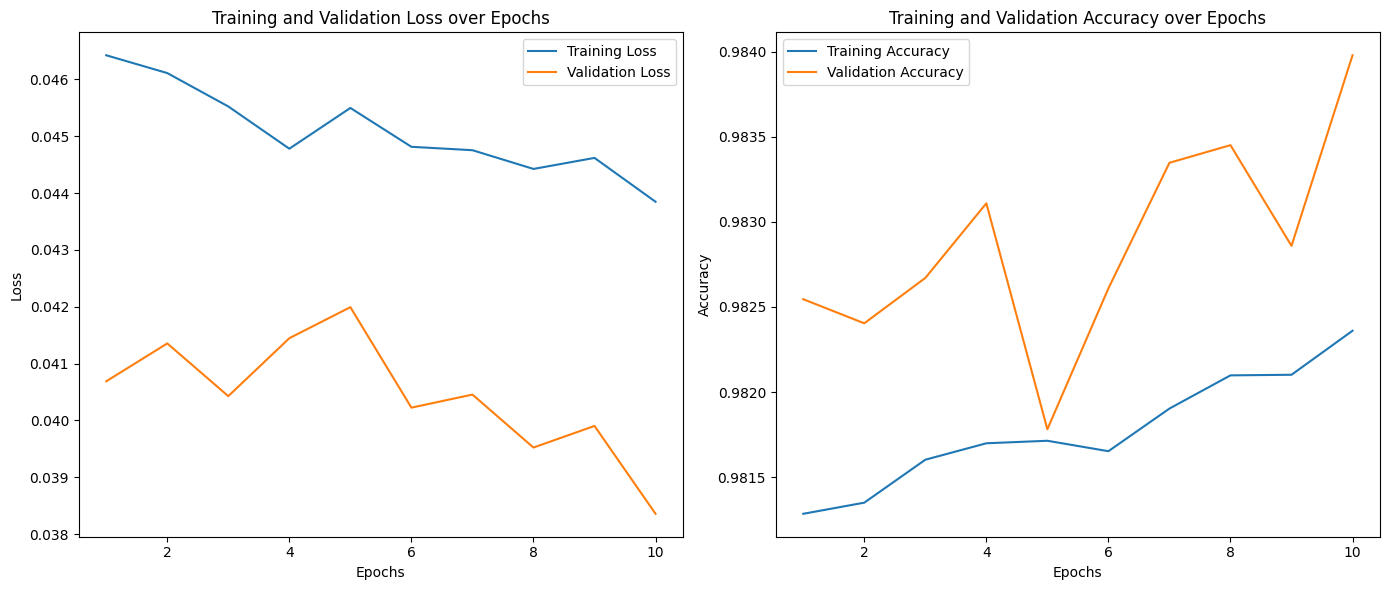

In [25]:
# Train the model and capture the training history
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    callbacks=[earlystop_callback],
    batch_size=128,
    validation_split=0.2  # Optional: to see validation performance
)

# Extract loss and accuracy for both training and validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
